# Mining SMS data from the UK, classifying spam messages

# Table of Contents
1. [Imports](#imports)
2. [Exploratory Data Analysis](#eda)
 1. [Text Preprocessing](#preprocessing)
 2. [Feature Engineering](#features)
 3. [Sentiment Analysis](#sentiment)
3. [Classification](#classification)

# 1. Imports <a class='anchor' id='imports'></a>

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD


# 2. Exploratory Data Analysis <a class='anchor' id='eda'></a>

We needed to specify names for the columns in order to be able to read the dataset correctly otherwise parsing text containing delimiter symbol would raise error

Also there were two null objects in texts so we dropped them

In [2]:
df = pd.read_csv(
    '../data/SmsCollection.csv',
    sep=';',
    names=['label', 'text'],
    skiprows=1,
    encoding='utf8').dropna()

df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5571
Data columns (total 2 columns):
label    5570 non-null object
text     5570 non-null object
dtypes: object(2)
memory usage: 130.5+ KB


In [4]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4823   4505                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [5]:
sns.set(
    style='whitegrid',
    palette='Set2',
    font_scale=1.4,
    rc={"figure.figsize": [10, 6]})


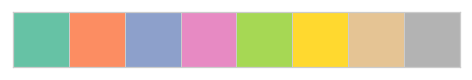

In [6]:
sns.palplot(sns.color_palette('Set2'))


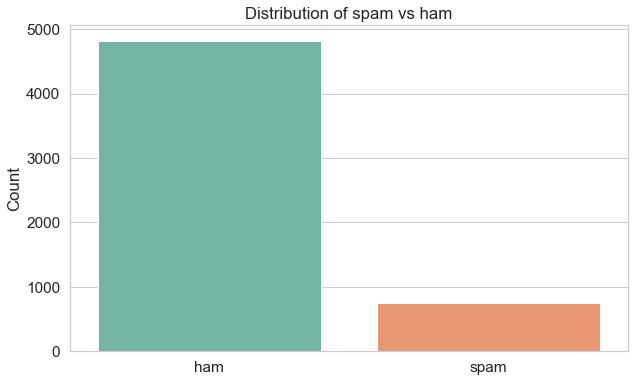

In [7]:
sns.countplot(df['label'])
plt.title('Distribution of spam vs ham')
plt.xlabel('')
plt.ylabel('Count')
plt.show()


## A. Text Preprocessing <a class='anchor' id='preprocessing'></a>

We clean the original textual data by removing non-alphanumeric characters, then we use the original Porter Stemmer to simplify the vocabulary variations, exclude stop words and numbers

In [8]:
# remove all non-alphanumeric characters
df['text_processed'] = df['text'].apply(
    lambda s: ' '.join(
        PorterStemmer().stem(word) for word in word_tokenize(re.sub(r'[^A-Za-z0-9 ]', ' ', s).lower())
        if not word in stop_words and not word.isdigit()
    )
)


In [9]:
print('Before:\n' + df['text'][42] + '\n\nAfter:\n' + str(df['text_processed'][42]))


Before:
07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow

After:
rodger burn msg tri call repli sm free nokia mobil free camcord pleas call deliveri tomorrow


## B. Feature Engineering <a class='anchor' id='features'></a>

In [10]:
print('Words:\n', word_tokenize(df['text_processed'][42]))
print('Count:\n', len(word_tokenize(df['text_processed'][42])))

Words:
 ['rodger', 'burn', 'msg', 'tri', 'call', 'repli', 'sm', 'free', 'nokia', 'mobil', 'free', 'camcord', 'pleas', 'call', 'deliveri', 'tomorrow']
Count:
 16


In [11]:
# number of words in a message
df['words_count'] = df.apply(
    lambda row: len([word for word in word_tokenize(row['text_processed'])
                     if not word.isdigit()]), axis=1)

df.head()


,label,text,text_processed,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,16
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,22
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,9
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,7


We can see the most common text size in a message

In [12]:
print('ham:\n',
      Counter(df.loc[df['label'] == 'ham']['words_count']).most_common(25))
print('spam:\n',
      Counter(df.loc[df['label'] == 'spam']['words_count']).most_common(25))

ham:
 [(3, 647), (4, 634), (5, 528), (6, 419), (7, 361), (2, 348), (8, 281), (9, 205), (10, 175), (11, 159), (12, 139), (13, 135), (14, 126), (1, 121), (15, 88), (16, 87), (17, 68), (20, 51), (18, 44), (19, 41), (21, 37), (22, 28), (23, 17), (25, 16), (24, 14)]
spam:
 [(16, 83), (17, 77), (15, 67), (18, 63), (19, 57), (14, 55), (13, 49), (12, 49), (11, 41), (20, 38), (21, 29), (22, 26), (10, 19), (4, 13), (23, 13), (9, 11), (7, 10), (6, 8), (8, 8), (24, 7), (5, 7), (25, 6), (3, 5), (2, 2), (1, 2)]


In [13]:
# number of characters in a message, i.e. message length (excluding spaces)
df['char_count'] = df['text_processed'].apply(
    lambda s: len(re.sub(r'[ ]', '', s)))

df.head()


,label,text,text_processed,words_count,char_count
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,16,61
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,22,98
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,9,27
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,7,30


We can see the most common text length (number of characters) in a message for both labels

In [14]:
print('ham:\n',
      Counter(df.loc[df['label'] == 'ham']['char_count']).most_common(25))
print('spam:\n',
      Counter(df.loc[df['label'] == 'spam']['char_count']).most_common(25))

ham:
 [(14, 176), (13, 163), (17, 159), (12, 148), (18, 146), (15, 141), (19, 138), (16, 132), (11, 129), (22, 127), (20, 125), (23, 114), (10, 102), (9, 102), (21, 101), (24, 101), (25, 96), (30, 93), (26, 93), (27, 90), (8, 89), (28, 87), (31, 76), (29, 72), (35, 71)]
spam:
 [(67, 24), (81, 22), (72, 22), (60, 20), (59, 19), (88, 18), (71, 18), (65, 18), (83, 18), (69, 17), (77, 17), (64, 17), (75, 17), (84, 17), (89, 17), (86, 16), (63, 16), (70, 15), (99, 15), (80, 14), (97, 14), (74, 14), (73, 14), (57, 14), (91, 14)]


We drop some of the rows in the data frame as their number of words/characters is less than 1 and the total number of such occurancies is 12 which will not significantly affect our dataset

In [15]:
df.loc[df['words_count'] < 1]

,label,text,text_processed,words_count,char_count
253,ham,What you doing?how are you?,,0,0
960,ham,Where @,,0,0
1612,ham,645,,0,0
2807,ham,Can a not?,,0,0
3376,ham,:),,0,0
4117,ham,What you doing?how are you?,,0,0
4575,ham,:( but your not here....,,0,0
4824,ham,:-) :-),,0,0


In [16]:
df.loc[df['char_count'] < 2]

,label,text,text_processed,words_count,char_count
253,ham,What you doing?how are you?,,0,0
805,ham,K I'll be there before 4.,k,1,1
960,ham,Where @,,0,0
1553,ham,U too...,u,1,1
1612,ham,645,,0,0
2807,ham,Can a not?,,0,0
3376,ham,:),,0,0
4117,ham,What you doing?how are you?,,0,0
4575,ham,:( but your not here....,,0,0
4824,ham,:-) :-),,0,0


In [17]:
df.drop(df.loc[df['char_count'] < 2].index, inplace=True)
df.drop(df.loc[df['words_count'] < 1].index, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5558 entries, 0 to 5571
Data columns (total 5 columns):
label             5558 non-null object
text              5558 non-null object
text_processed    5558 non-null object
words_count       5558 non-null int64
char_count        5558 non-null int64
dtypes: int64(2), object(3)
memory usage: 260.5+ KB


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


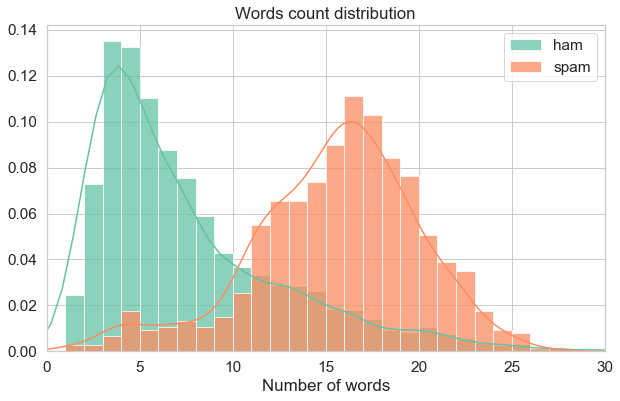

In [18]:
sns.distplot(
    df.loc[df['label'] == 'ham']['words_count'],
    bins=np.arange(0, 30),
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['words_count'],
    bins=np.arange(0, 30),
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 30)
plt.xlabel('Number of words')
plt.title('Words count distribution')
plt.legend()
plt.show()


In principle the KDEs have to be similar to the previous ones

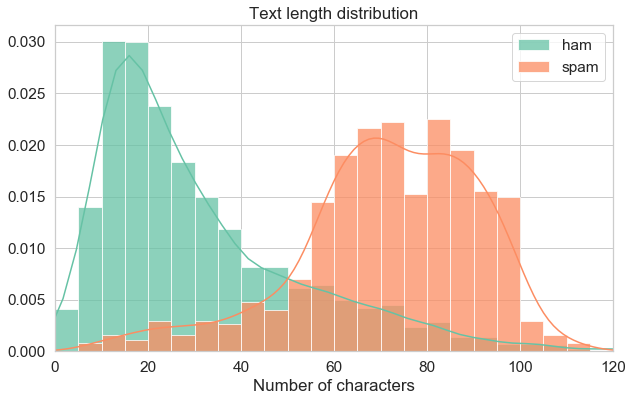

In [19]:
sns.distplot(
    df.loc[df['label'] == 'ham']['char_count'],
    bins=np.arange(0, 120, 5),
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['char_count'],
    bins=np.arange(0, 120, 5),
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 120)
plt.xlabel('Number of characters')
plt.title('Text length distribution')
plt.legend()
plt.show()


We can see some outliers after 140 characters and about 180 words

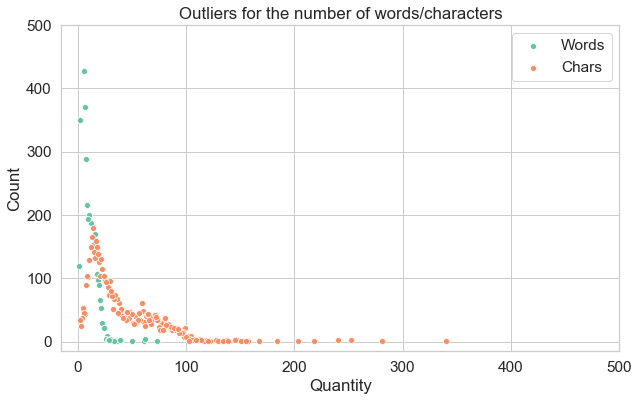

In [20]:
sns.scatterplot(
    x=list(Counter(df['words_count']).keys()),
    y=list(Counter(df['words_count']).values()),
    label='Words')

sns.scatterplot(
    x=list(Counter(df['char_count']).keys()),
    y=list(Counter(df['char_count']).values()),
    label='Chars')

plt.xlim(-15, 500)
plt.ylim(-15, 500)
plt.title('Outliers for the number of words/characters')
plt.ylabel('Count')
plt.xlabel('Quantity')
plt.legend()
plt.show()


We now can calculate the average word length per text message as a feature and see the distribution of it

In [21]:
# average word length in a text
df['avg_word_length'] = df.char_count / df.words_count

df.head()

,label,text,text_processed,words_count,char_count,avg_word_length
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,16,61,3.812500
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6,16,2.666667
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,22,98,4.454545
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,9,27,3.000000
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,7,30,4.285714


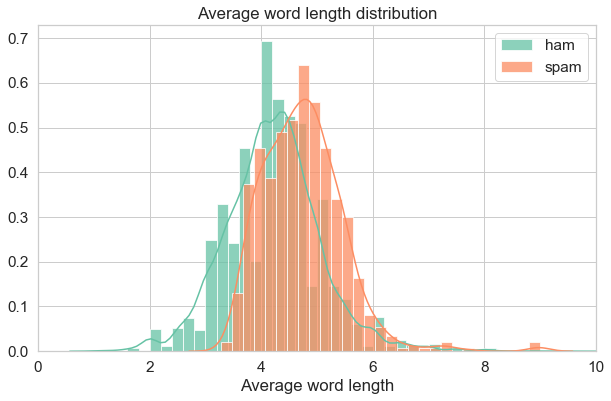

In [22]:
sns.distplot(
    df.loc[df['label'] == 'ham']['avg_word_length'],
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['avg_word_length'],
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 10)
plt.xlabel('Average word length')
plt.title('Average word length distribution')
plt.legend()
plt.show()


### C. Sentiment Analysis <a class='anchor' id='sentiment'></a>

For the sentiment analysis we use the original data without cleaning as the VADER sentiment analysis tool already takes care of the preprocessing and it is especially tailored to use for internet text lexicon as it is seen to be used in the text messages

In [23]:
%%time
df = pd.concat([
    df, df['text'].apply(
        lambda s: SentimentIntensityAnalyzer().polarity_scores(s)).apply(
            pd.Series)
],
               axis=1)

CPU times: user 52 s, sys: 944 ms, total: 53 s
Wall time: 53 s


After we calculate the sentiment intensity we then mark the messages as positive/negative/neutral based on the compound component

In [24]:
df.loc[(df['compound'] > -.05) &
       (df['compound'] < .05), 'sentiment'] = 'neutral'
df.loc[df['compound'] <= -.05, 'sentiment'] = 'negative'
df.loc[df['compound'] >= .05, 'sentiment'] = 'positive'

df.head()


,label,text,text_processed,words_count,char_count,avg_word_length,neg,neu,pos,compound,sentiment
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,16,61,3.812500,0.000,0.806,0.194,0.6249,positive
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6,16,2.666667,0.000,0.423,0.577,0.4767,positive
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,22,98,4.454545,0.000,0.772,0.228,0.7964,positive
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,9,27,3.000000,0.000,1.000,0.000,0.0000,neutral
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,7,30,4.285714,0.113,0.887,0.000,-0.1027,negative


Now we can plot the results of the sentiment analysis and see the distribution for each label

In [25]:
print('overall:', Counter(df['sentiment']))
print('ham:', Counter(df.loc[df['label'] == 'ham']['sentiment']))
print('spam:', Counter(df.loc[df['label'] == 'spam']['sentiment']))


overall: Counter({'positive': 2625, 'neutral': 1943, 'negative': 990})
ham: Counter({'positive': 2080, 'neutral': 1846, 'negative': 885})
spam: Counter({'positive': 545, 'negative': 105, 'neutral': 97})


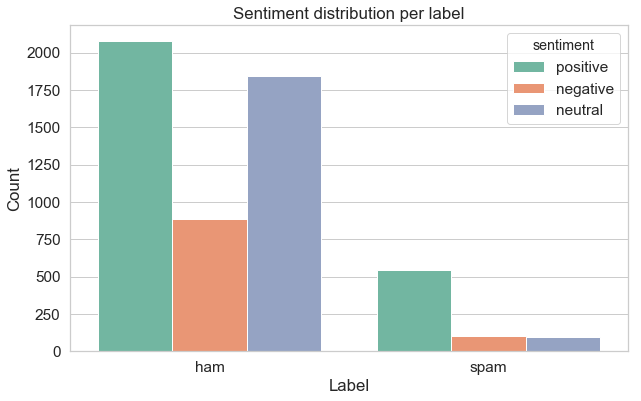

In [26]:
sns.countplot(
    x='label',
    hue='sentiment',
    data=df,
    hue_order=['positive', 'negative', 'neutral'])

plt.title('Sentiment distribution per label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Let's now see the most common words for both labels. For this we exclude stop words and plot a word cloud.

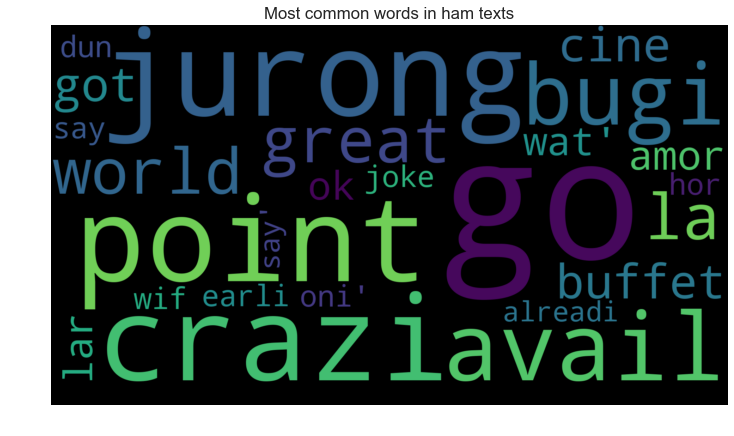

In [27]:
df_plot = df.loc[df['label'] == 'ham']['text_processed']

word_cloud = WordCloud(
    max_words=25, stopwords=stop_words, margin=10, width=1920,
    height=1080).generate(str(df_plot.values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in ham texts')
plt.show()


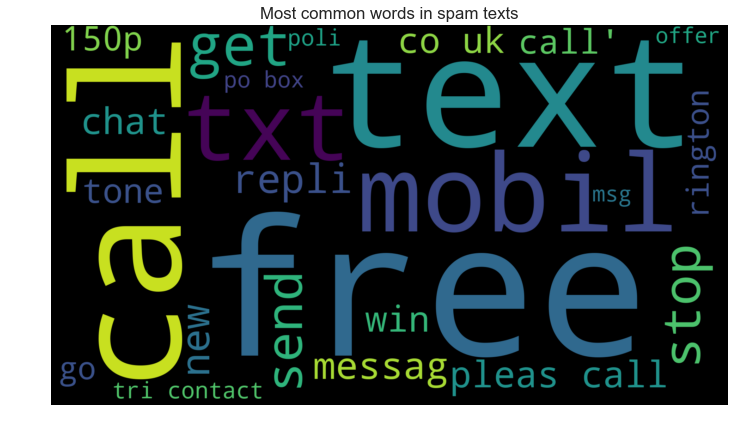

In [28]:
df_plot = df.loc[df['label'] == 'spam']['text_processed']

word_cloud = WordCloud(
    max_words=25, stopwords=stop_words, margin=10, width=1920,
    height=1080).generate(str(df_plot.values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in spam texts')
plt.show()


Finally we will add a new feature - first we create a list of most common words in spam messages and then for each text we count a number of words which fall in this list

In [29]:
Counter(word for word in word_tokenize(str(df_plot.values))).most_common(25)


[('call', 323),
 ('txt', 170),
 ('free', 170),
 ('u', 148),
 ('text', 139),
 ('mobil', 129),
 ('ur', 124),
 ('claim', 112),
 ('repli', 108),
 ('stop', 99),
 ('www', 97),
 ('prize', 87),
 ('get', 80),
 ('tone', 77),
 ('cash', 74),
 ('send', 70),
 ('min', 69),
 ('week', 65),
 ('nokia', 64),
 ('uk', 63),
 ('award', 61),
 ('servic', 60),
 ('contact', 58),
 ('phone', 57),
 ('win', 56)]

In [30]:
spam_list = [
    s for s, _ in Counter(
        word for word in word_tokenize(str(df_plot.values))).most_common(25)
]


In [31]:
df['spam_words'] = df['text_processed'].apply(
    lambda s: len([word for word in word_tokenize(s) if word in spam_list]))

df.head()


,label,text,text_processed,words_count,char_count,avg_word_length,neg,neu,pos,compound,sentiment,spam_words
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,16,61,3.812500,0.000,0.806,0.194,0.6249,positive,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6,16,2.666667,0.000,0.423,0.577,0.4767,positive,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,22,98,4.454545,0.000,0.772,0.228,0.7964,positive,4
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,9,27,3.000000,0.000,1.000,0.000,0.0000,neutral,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,7,30,4.285714,0.113,0.887,0.000,-0.1027,negative,0


# 3. Classification <a class='anchor' id='classification'></a>

In [32]:
# encode labels
df['label'] = LabelEncoder().fit_transform(df['label'])

# vectorize the texts into bag of words feature
bow = CountVectorizer().fit_transform(df['text_processed'])

# drop textual columns for classification
df.drop(['text', 'sentiment'], axis=1, inplace=True)

df.head()


,label,text_processed,words_count,char_count,avg_word_length,neg,neu,pos,compound,spam_words
0,0,go jurong point crazi avail bugi n great world...,16,61,3.812500,0.000,0.806,0.194,0.6249,0
1,0,ok lar joke wif u oni,6,16,2.666667,0.000,0.423,0.577,0.4767,1
2,1,free entri wkli comp win fa cup final tkt 21st...,22,98,4.454545,0.000,0.772,0.228,0.7964,4
3,0,u dun say earli hor u c alreadi say,9,27,3.000000,0.000,1.000,0.000,0.0000,2
4,0,nah think goe usf live around though,7,30,4.285714,0.113,0.887,0.000,-0.1027,0


In [33]:
# stack bag of words with other numerical features in a numpy array
supervised_features = sparse.hstack((bow, df.iloc[:, 2:].values))


In [34]:
print([x for x in supervised_features.toarray()[42] if x > 0])


[1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 16.0, 77.0, 4.8125, 0.737, 0.263, 0.836, 7.0]


In [35]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    supervised_features, df['label'], test_size=.33)

print('X_train:', X_train.shape[0])
print('X_test:', X_test.shape[0])
print('y_train:', y_train.shape[0])
print('y_test:', y_test.shape[0])


X_train: 3723
X_test: 1835
y_train: 3723
y_test: 1835


In [36]:
# K-Neighbours classsification

# fit the model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# run on the test set
y_knc = model.predict(X_test)

In [37]:
# cross validation
scores = cross_val_score(model, supervised_features, df['label'], cv=5)

In [38]:
print('KNeighbors accuracy score:', accuracy_score(y_test, y_knc))
print('KNeighbors confusion matrix:\n', confusion_matrix(y_test, y_knc))
print('KNeighbors cross-validation scores:', scores)
print('KNeighbors final score after cross-validation: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

KNeighbors accuracy score: 0.9536784741144414
KNeighbors confusion matrix:
 [[1551   38]
 [  47  199]]
KNeighbors cross-validation scores: [0.95148248 0.95503597 0.96579658 0.94239424 0.96309631]
KNeighbors final score after cross-validation: 0.96 (+/- 0.02)


In [39]:
# Random Forest classification

# fit the model
model = RandomForestClassifier(n_estimators=42)
model.fit(X_train, y_train)

# run on the test set
y_rfc = model.predict(X_test)

In [40]:
# cross validation
scores = cross_val_score(model, supervised_features, df['label'], cv=5)

In [41]:
print('Random Forest accuracy score:', accuracy_score(y_test, y_rfc))
print('Random Forest confusion matrix:\n', confusion_matrix(y_test, y_rfc))
print('Random Forest cross-validation scores:', scores)
print('Random Forest final score after cross-validation: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Random Forest accuracy score: 0.9754768392370572
Random Forest confusion matrix:
 [[1588    1]
 [  44  202]]
Random Forest cross-validation scores: [0.97753819 0.97392086 0.97749775 0.97389739 0.98019802]
Random Forest final score after cross-validation: 0.98 (+/- 0.00)


In theory these results could be improved by using TFIDF vectors instead of BoW